# Section 20: Network-Driven Supervised Machine Learning

## 20.1 The Basics of Supervised Machine Learning

We want to construct a model that maps inputted iris measurements to one of three species categories. In machine learning, these inputted measurements are called **features**. Meanwhile, the outputted categories are called **classes**. The goal of supervised learning is to construct a model that can identify classes based on features. Such a model is called a **classifier**.

As seen in Section Fourteen, we can load known iris features and class labels using Scikit-Learn’s `load_iris` function. 

**Listing 20. 1. Loading iris features and class labels**

In [1]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
num_classes = len(set(y))
print(f"We have {y.size} labeled examples across the following "
      f"{num_classes} classes:\n{set(y)}\n")
print(f"First four feature rows:\n{X[:4]}")
print(f"\nFirst four labels:\n{y[:4]}")

We have 150 labeled examples across the following 3 classes:
{0, 1, 2}

First four feature rows:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]]

First four labels:
[0 0 0 0]


All 150 flower measurements have been labeled as belonging to one of three flower species. Imagine that we only have the resources to label one-fourth of the flowers. We'd label the adata then train a model to predict the classes of the remaining flowers. Lets simulate this scenario.

**Listing 20. 2. Creating a training set**

In [2]:
sampling_size = int(y.size / 4)
X_train, y_train = X[:sampling_size], y[:sampling_size]
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Our training set contains just the labeled examples with _Species 0_. The remaining two flower species are not represented. In order to increase representation, we should sample at random from `X` and `y`.

**Listing 20. 3. Creating a training set through random sampling**

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25)
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1 2 0]


As we saw in Section Fourteen, the features within the iris dataset can be plotted in multi-dimensional space. This plotted data forms spatial clusters. Hence, elements in `X_test` are more likely to share their class with the `X_train` points found in the adjacent cluster. 

**Listing 20. 4. Plotting the training and test sets**

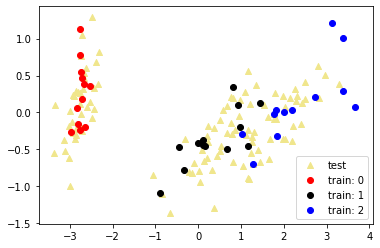

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA()
transformed_data_2D = pca_model.fit_transform(X_train)

unlabeled_data = pca_model.transform(X_test)
plt.scatter(unlabeled_data[:,0], unlabeled_data[:,1],
            color='khaki', marker='^', label='test')

for label in range(3):
    data_subset = transformed_data_2D[y_train == label]
    plt.scatter(data_subset[:,0], data_subset[:,1],
            color=['r', 'k', 'b'][label], label=f'train: {label}')

plt.legend()
plt.show()

Many unlabeled points cluster around _Species 0_. These unlabeled flowers clearly belong to the same species. Elsewhere in the plot, certain unlabeled flowers are proximate to both _Species 1_ and _Species 2_. For each such point, we'll need to quantify which labeled species are closer. This will require us to track the Euclidean distance between each feature in `X_test` and each feature in `X_train`. 

**Listing 20. 5. Computing Euclidean distances between points**

In [5]:
from sklearn.metrics.pairwise import euclidean_distances
distance_matrix = euclidean_distances(X_test, X_train)

f_train, f_test = X_test[0], X[0]
distance = distance_matrix[0][0]
print(f"Our first test set feature is {f_train}")
print(f"Our first training set feature is {f_test}")
print(f"The Euclidean distance between the features is {distance:.2f}")

Our first test set feature is [5.8 2.8 5.1 2.4]
Our first training set feature is [5.1 3.5 1.4 0.2]
The Euclidean distance between the features is 4.18


We can assume that each unlabeled point shares a class that is common to its neighbors. This strategy forms the basis for the **K-nearest Neighbors** algorithm, which referred to as **KNN** for short. 

**Listing 20. 6. Labeling a point based on its nearest neighbors**

In [6]:
from collections import Counter
np.random.seed(6)
random_index = np.random.randint(y_test.size)
labeled_distances = distance_matrix[random_index]
labeled_neighbors = np.argsort(labeled_distances)[:3]
labels = y_train[labeled_neighbors]

top_label, count = Counter(labels).most_common()[0]
print(f"The 3 nearest neigbhors of Point {random_index} have the "
      f"following labels:\n{labels}")
print(f"\nThe most common class label is {top_label}. It occurs {count} "
       "times.")

The 3 nearest neigbhors of Point 10 have the following labels:
[2 1 2]

The most common class label is 2. It occurs 2 times.


The most common class label among the neighbors of _Point 10_ is _Label 2_. How does this compare to the actual class of the flower?

**Listing 20. 7. Checking the true class of a predicted label**

In [7]:
true_label = y_test[random_index]
print(f"The true class of Point {random_index} is {true_label}.")

The true class of Point 10 is 2.


We can reformulate KNN as a graph theory problem. We can treat each point as a node, and it’s labeled as a node attribute. Afterwards, we can choose an unlabeled point and extend edges to its K closest labeled neighbors. Visualizing the neighbor graph subsequently allows us to identify the point.

**Listing 20. 8. Visualizing nearest neighbors with NetworkX**

/Library/Python/3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


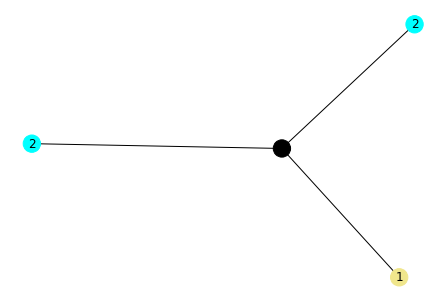

In [8]:
import networkx as nx
np.random.seed(0)

def generate_neighbor_graph(unlabeled_index, labeled_neighbors):
    G = nx.Graph()
    nodes = [(i, {'label': y_train[i]}) for i in labeled_neighbors]
    nodes.append((unlabeled_index, {'label': 'U'}))
    G.add_nodes_from(nodes)
    G.add_edges_from([(i, unlabeled_index) for i in labeled_neighbors])
    labels = y_train[labeled_neighbors]
    label_colors = ['pink', 'khaki', 'cyan']
    colors = [label_colors[y_train[i]] for i in labeled_neighbors] + ['k']
    labels = {i: G.node[i]['label'] for i in G.nodes}
    nx.draw(G, node_color=colors, labels=labels, with_labels=True)
    plt.show()
    return G
    
G = generate_neighbor_graph(random_index, labeled_neighbors)

KNN works when there are just three neighbors. What happens if we increase the neighbor count to four?

**Listing 20. 9. Increasing the number of nearest neighbors**

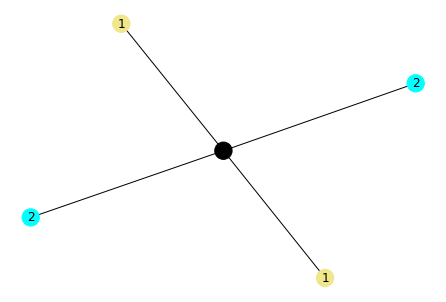

In [9]:
np.random.seed(0)
labeled_neighbors = np.argsort(labeled_distances)[:4]
G = generate_neighbor_graph(random_index, labeled_neighbors)

There is a tie! We can break that tie by weighing label-votes based on the inverse distance to the unlabeled point.

**Listing 20. 10. Weighing votes of neighbors based on distance**

In [10]:
from collections import defaultdict
class_to_votes = defaultdict(int)
for node in G.neighbors(random_index):
    label = G.nodes[node]['label']
    distance = distance_matrix[random_index][node]
    num_votes = 1 / distance
    print(f"A data point with a label of {label} is {distance:.2f} units "
          f"away. It receives {num_votes:.2f} votes.")
    class_to_votes[label] += num_votes
  
print()
for class_label, votes in class_to_votes.items():
    print(f"We counted {votes:.2f} votes for class {class_label}.")
    
top_class = max(class_to_votes.items(), key=lambda x: x[1])[0]
print(f"Class {top_class} has received the plurality of the votes.")

A data point with a label of 2 is 0.54 units away. It receives 1.86 votes.
A data point with a label of 1 is 0.74 units away. It receives 1.35 votes.
A data point with a label of 2 is 0.77 units away. It receives 1.29 votes.
A data point with a label of 1 is 0.98 units away. It receives 1.02 votes.

We counted 3.15 votes for class 2.
We counted 2.36 votes for class 1.
Class 2 has received the plurality of the votes.


## Measuring Predicted Label Accuracy

We want to analyze predictions across all the points within `X_test`. We'll define a `predict` function for this purpose.

**Listing 20. 11. Parameterizing KNN predictions**

In [11]:
def predict(index, K=1, weighted_voting=False):
    labeled_distances = distance_matrix[index]
    labeled_neighbors = np.argsort(labeled_distances)[:K]
    class_to_votes = defaultdict(int)
    for neighbor in labeled_neighbors:
        label = y_train[neighbor]
        distance = distance_matrix[index][neighbor]
        num_votes = 1 / max(distance, 1e-10) if weighted_voting else 1
        class_to_votes[label] += num_votes
    return max(class_to_votes, key=lambda x: class_to_votes[x])

assert predict(random_index, K=3) == 2
assert predict(random_index, K=4, weighted_voting=True) == 2

Lets execute `predict` across all unlabeled indices.

**Listing 20. 12. Predicting all unlabeled flower classes**

In [12]:
y_pred = np.array([predict(i) for i in range(y_test.size)])

We want to compare the predicted classes with the actual classes in `y_test`. Lets start by printing out both the `y_pred` and the `y_test` arrays.

**Listing 20. 13. Comparing the predicted and actual classes**

In [13]:
print(f"Predicted Classes:\n{y_pred}")
print(f"\nActual Classes:\n{y_test}")

Predicted Classes:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 2 0 2 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0 1 2 2 1 2 1 2 1 1 1 1 1 1 1 2 1 0 2 1 1 1 2 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]

Actual Classes:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]


It's easier to compare the two arrays if we aggregate them into a **cofusion matrix**.  The matrix rows will track predicted classes, while the columns will track the true class identities. 

**Listing 20. 14. Computing the confusion matrix**

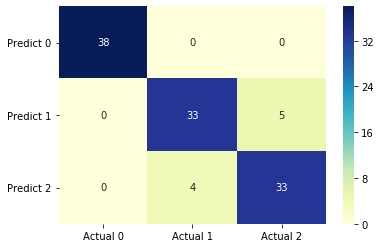

In [15]:
import seaborn as sns
def compute_confusion_matrix(y_pred, y_test): 
    num_classes = len(set(y_pred) | set(y_test))
    confusion_matrix = np.zeros((num_classes, num_classes))
    for prediction, actual in zip(y_pred, y_test):
        confusion_matrix[prediction][actual] += 1
    
    return confusion_matrix
    

M = compute_confusion_matrix(y_pred, y_test)
sns.heatmap(M, annot=True, cmap='YlGnBu',
            yticklabels=[f"Predict {i}" for i in range(3)],
            xticklabels = [f"Actual {i}" for i in range(3)])
plt.yticks(rotation=0)
plt.show()

Each diagonal element `M[i][i]` tracks the number of accurately predicted instances of _Class i_. Such accurate predictions are commonly called **true positives**.

**Listing 20. 15. Counting the number of accurate predictions**

In [16]:
num_accurate_predictions = M.diagonal().sum()
print(f"Our results contain {int(num_accurate_predictions)} accurate "
       "predictions.")

Our results contain 104 accurate predictions.


The fraction of total accurate predictions is referred to as the **accuracy** score. Accuracy can be computed dividing the diagonal sum across the total sum of matrix elements.

**Listing 20. 16. Measuring the accuracy score**

In [17]:
accuracy = M.diagonal().sum() / M.sum()
assert accuracy == 104 / (104 + 9)
print(f"Our predictions are {100 * accuracy:.0f}% accurate.")

Our predictions are 92% accurate.


Errors present in the output. The model periodically confuses instances of _Classes 1_ and _2_. Lets try to quantify that confusion. First, we'll couunt the total number of elements that we've predicted as belonging to _Class 1_. 

**Listing 20. 17. Counting the predicted Class 1 elements**

In [18]:
row1_sum = M[1].sum()
print(f"We've predicted that {int(row1_sum)} elements belong to Class 1.")

We've predicted that 38 elements belong to Class 1.


We've predicted that 38 elements belong to _Class 1_. 33 predictions are true positives. Meanwhile, the remaining 5 predictions are **false positives**. The ratio `33 / 38` produces a metric called **precision**. A low precision indicates that a predicted class label is not very reliable. 

**Listing 20. 18. Computing the precision of Class 1**

In [19]:
precision = M[1][1] / M[1].sum()
assert precision == 33 / 38
print(f"Precision of Class 1 is {precision:.2f}")

Precision of Class 1 is 0.87


Errors can also be detected across the confusion matrix columns. Consider for example, _Column 1_. That column tracks all elements in `y_test` whose true label is equal to _Class 1_. 

**Listing 20. 19. Counting the total Class 1 elements**

In [20]:
col1_sum = M[:,1].sum()
assert col1_sum == y_test[y_test == 1].size
print(f"{int(col1_sum)} elements in our test set belong to Class 1.")

37 elements in our test set belong to Class 1.


37 elements in our test set belong to _Class 1_. 33 of the elements are true positives. The remaining 4 elements are **false negatives**. The ratio `33 / 37` produces a metric called **recall**. A low recall indicates that our predictor commonly misses valid instances of a class.

**Listing 20. 20. Computing the recall of Class 1**

In [21]:
recall = M[1][1] / M[:,1].sum()
assert recall == 33 / 37
print(f"Recall of Class 1 is {recall:.2f}")

Recall of Class 1 is 0.89


A maximum recall of 1.0 is trivial to achieve. We simply need to label each incoming data-point as belonging to _Class 1_. However, this will cause precision to drop drastically. 

**Listing 20. 21. Checking precision at a recall of 1.0**

In [22]:
low_precision = M[1][1] / M.sum() 
print(f"Precision at a trivially maximized recall is {low_precision:.2f}")

Precision at a trivially maximized recall is 0.29


We should combine precision and recall into a single metric. However, we can't average these values because they are fractions with different denominators. Fortunately, their numerators are both equal to `M[1][1]`. Thus, we can inverted the fractions and then take their average.

**Listing 20. 22. Taking the mean of the inverted metrics**

In [23]:
inverse_average = (1 / precision + 1 / recall) / 2
print(f"The average of inverted metrics is {inverse_average:.2f}")

The average of inverted metrics is 1.14


The average of the inverses is higher than 1.0. However, both precision and recall have a maximum ceiling of 1.0. We can force the aggregated value to fall within that range by taking an inverse of the average.

**Listing 20. 23. Taking the inverse of the inverted mean**

In [24]:
result = 1 / inverse_average
print(f"The inverse of average is {result:.2f}")

The inverse of average is 0.88


Our aggregated metric is called the **f1-measure** or **f1-score**. Commonly, its referred to as simply the **f-measure**. The f-measure can be computed more directly by running `2 * precision * recall / (precision + recall)`.

**Listing 20. 24. Computing the f-measure of Class 1**

In [25]:
f_measure = 2 * precision * recall / (precision + recall)
print(f"The f-measure of Class 1 is {f_measure:.2f}")

The f-measure of Class 1 is 0.88


In this instance, the f-measure is equal to the average of the precision and recall. However this is not always the case. Consider a prediction that has one true positive, one false positive, and zero false negatives. 

**Listing 20. 25. Comparing the f-measure to the average**

In [26]:
tp, fp, fn = 1, 1, 0
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_measure = 2 * precision * recall / (precision + recall)
average = (precision + recall) / 2
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Average: {average}")
print(f"F-measure: {f_measure:.2f}")

Precision: 0.5
Recall: 1.0
Average: 0.75
F-measure: 0.67


The f-measure provides us with a robust evaluation for an individual class. Within this in mind, we'll now compute the f-measure for each class within our dataset.

**Listing 20. 26. Computing the f-measure for each class**

In [27]:
def compute_f_measures(M):
    precisions = M.diagonal() / M.sum(axis=0)
    recalls = M.diagonal() / M.sum(axis=1)
    return 2 * precisions * recalls / (precisions + recalls)
    
f_measures = compute_f_measures(M)
for class_label, f_measure in enumerate(f_measures):
    print(f"The f-measure for Class {class_label} is {f_measure:.2f}")

The f-measure for Class 0 is 1.00
The f-measure for Class 1 is 0.88
The f-measure for Class 2 is 0.88


We computed three f-measures across three different classes. These f-measures can be combined into a single score by taking their mean.

**Listing 20. 26. Computing the f-measure for each class**

In [28]:
avg_f = f_measures.mean()
print(f"Our unified f-measure equals {avg_f:.2f}")

Our unified f-measure equals 0.92


The f-measure is identical to our accuracy. However, thet f-measure and accuracy are not guaranteed to be the same. The difference between the metrics is especially noticeable when the classes are **imbalanced**. In an imbalanced dataset, there are way more instances of some _Class A_ than of another _Class B_.

**Listing 20. 28. Comparing performance metrics across imbalanced data**

In [29]:
M_imbalanced = np.array([[99, 0], [1, 1]])
accuracy_imb = M_imbalanced.diagonal().sum() / M_imbalanced.sum()
f_measure_imb =  compute_f_measures(M_imbalanced).mean()
print(f"The accuracy for our imbalanced dataset is {accuracy_imb:.2f}")
print(f"The f-measure for our imbalanced dataset is {f_measure_imb:.2f}")

The accuracy for our imbalanced dataset is 0.99
The f-measure for our imbalanced dataset is 0.83


#### Scikit-Learn's Prediction Measurement Functions
All the prediction metrics that we've discussed thus far are available in Scikit-Learn. They can be imported from the `sklearn.metrics` module. For instance, we can compute the confusion matrix by importing and running `confusion_matrix`.

**Listing 20. 29. Computing the confusion matrix using Scikit-Learn**

In [30]:
from sklearn.metrics import confusion_matrix
new_M = confusion_matrix(y_pred, y_test)
assert np.array_equal(new_M, M)
print(new_M)

[[38  0  0]
 [ 0 33  5]
 [ 0  4 33]]


In that same manner, we can compute the accuracy by importing and running `accuracy_score`.

**Listing 20. 30. Computing the accuracy using Scikit-Learn**

In [31]:
from sklearn.metrics import accuracy_score
assert accuracy_score(y_pred, y_test) == accuracy

Also, the f-measure can be computed with the `f1_score` function. Passing `average=None` into the function will return a vector of individual f-measures for each class.

**Listing 20. 31. Computing all f-measures using Scikit-Learn**

In [32]:
from sklearn.metrics import f1_score
new_f_measures = f1_score(y_pred, y_test, average=None)
assert np.array_equal(new_f_measures, f_measures)
print(new_f_measures)

[1.   0.88 0.88]


Meanwhile, passing `average='macro'` will return a single average score.

**Listing 20. 32. Computing a unified f-measures using Scikit-Learn**

In [33]:
new_f_measure = f1_score(y_pred, y_test, average='macro')
assert new_f_measure == new_f_measures.mean()
assert new_f_measure == avg_f

## Optimizing KNN Performance

Currently, our `predict` function takes two input parameters: `K` and `weighted_voting`. These parameters must be set prior to training, and will influence the classifier's performance. Data scientists refer to such parameters as **hyperparameters**. Lets try to optimize our classifier's hyperparameters by iterating over all possible combinations of `K` and `weighted_voting`.

**Listing 20. 33. Optimizing KNN hyperparameters**

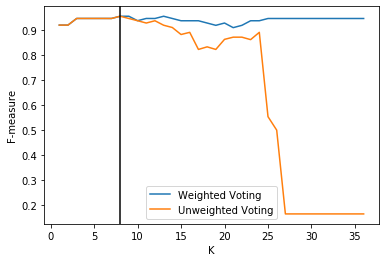

In [34]:
k_values = range(1, y_train.size)
weighted_voting_bools = [True, False]
f_scores = [[], []]

params_to_f = {}
for k in k_values:
    for i, weighted_voting in enumerate(weighted_voting_bools):
        y_pred = np.array([predict(i, K=k, 
                           weighted_voting=weighted_voting) 
                        for i in range(y_test.size)])
        f_measure = f1_score(y_pred, y_test, average='macro')
        f_scores[i].append(f_measure)
        params_to_f[(k, weighted_voting)] = f_measure

(best_k, best_weighted), best_f = max(params_to_f.items(), 
                                      key=lambda x: x[1])
plt.plot(k_values, f_scores[0], label='Weighted Voting')
plt.plot(k_values, f_scores[1], label='Unweighted Voting')
plt.axvline(best_k, c='k')
plt.xlabel('K')
plt.ylabel('F-measure')
plt.legend()
plt.show()

We've optimized performance exhaustively iterating over all the possible input parameters. This exhaustive approach is called a **parameter sweep**, or a **grid search**.

## Running Grid Search Using Scikit-Learn

Scikit-Learn has a built-in model for running KNN classification. In order to utilize this model, we must import the `KNeighborsClassifier` class.

**Listing 20. 34. Importing Scikit-Learn’s KNN class**

In [35]:
from sklearn.neighbors import KNeighborsClassifier

Initializing the class will create a KNN classifier object. Per common convention, we'll store this object in a `clf` variable.

**Listing 20. 35. Initializing Scikit-Learn’s KNN classifier**

In [36]:
clf = KNeighborsClassifier()

The initialized `clf` object has preset specifications for K and weighted voting.

**Listing 20. 36. Printing the preset KNN parameters**

In [37]:
K = clf.n_neighbors
weighted_voting = clf.weights
print(f"K is set to {K}.")
print(f"Weighted voting is set to '{weighted_voting}'.")

K is set to 5.
Weighted voting is set to 'uniform'.


We can reinitialize `clf` with custom parameters.
**Listing 20. 37. Setting Scikit-Learn’s KNN parameters**

In [38]:
clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
assert clf.n_neighbors == 4
assert clf.weights == 'distance'

Now, we'll want to train our KNN model. Any Scikit-Learn `clf` classifier can be trained using the `fit` method.

**Listing 20. 38. Training Scikit-Learn’s KNN classifier**

In [39]:
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

After training, `clf` can predict the classes of any input `X_test` matrix (whose dimensions match `X_train`). Predictions are carried out with the `clf.predict` method.

**Listing 20. 39. Predicting classes with a trained KNN classifier**

In [40]:
y_pred = clf.predict(X_test)
f_measure = f1_score(y_pred, y_test, average='macro')
print(f"The predicted classes are:\n{y_pred}")
print(f"\nThe f-measure equals {f_measure:.2f}.")

The predicted classes are:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0 1 2 2 1 2 1 2 1 1 1 1 1 1 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]

The f-measure equals 0.95.


Additionally, `clf` allows to extract more nuanced prediction output. For instance, we can generate the fraction of the votes received by class for an inputted sample in `X_test`.

**Listing 20. 40. Outputting vote ratios for each class**

In [41]:
vote_ratios = clf.predict_proba(X_test)
print(vote_ratios[:4])

[[0.         0.21419074 0.78580926]
 [0.         1.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]]


Now, lets turn our attention to running grid search across `KNeighborsClassifier`. First we'll need to specify a dictionary mapping between our hyperparameters and their value-ranges.

**Listing 20. 41. Defining a hyperparameter dictionary**

In [42]:
hyperparams = {'n_neighbors': range(1, 40),
              'weights': ['uniform', 'distance']}

Next, we'll need to import Scikit-Learn's `GridSearchCV` class, which we'll use to execute the grid search.

**Listing 20. 42. Importing Scikit-Learn’s grid search class**

In [43]:
from sklearn.model_selection import GridSearchCV

Now, we'll initialize the `GridSearchCV` class by passing the hyperparameter dictionary.

**Listing 20. 43. Initializing Scikit-Learn’s grid search class**

In [44]:
clf_grid = GridSearchCV(KNeighborsClassifier(), hyperparams, 
                        scoring='f1_macro')

Running `clf_grid.fit(X, y)` will carry out the grid search.

**Listing 20. 44. Running a grid search using Scikit-Learn**

In [45]:
clf_grid.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 40),
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro')

We've executed the grid-search. The optimized hyperparameters are stored within the `clf_grid.best_params_` attribute. Likewise, the f-measure associated with these parameters is stored within `clf_grid.best_score_`.

**Listing 20. 45. Checking the optimized grid search results**

In [46]:
best_f = clf_grid.best_score_
best_params = clf_grid.best_params_
print(f"A maximum f-measure of {best_f:.2f} is achieved with the "
      f"following hyperparameters:\n{best_params}")

A maximum f-measure of 0.99 is achieved with the following hyperparameters:
{'n_neighbors': 10, 'weights': 'distance'}


The optimized KNN classifier is stored within the `clf_grid.best_estimator_` attribute.

**Listing 20. 46. Accessing the optimized classifier**

In [47]:
clf_best = clf_grid.best_estimator_
assert clf_best.n_neighbors == best_params['n_neighbors']
assert clf_best.weights == best_params['weights']

By leveraging `clf_best`, we can carry out predictions on new data. Alternatively, we can carry-out predictions directly with our optimized `clf_grid` object, by running `clf_grid.predict`.

**Listing 20. 47. Generating predictions with `clf_grid`**

## Limitations of the KNN Algorithm

he biggest problem with KNN is its speed. The algorithm can be very slow to run when the training set is large.
We'll illustrate this slow-down by increasing elements within our training set `(X, y)` by 2000-fold. Afterwards, we'll time the grid-search process for the expanded data. **The code will take approximately 15 mintues to run. Hence, it has been commented out.**

**Listing 20. 48. Optimizing KNN on a large training set**

In [48]:
""" 
import time
X_large = np.vstack([X for _ in range(2000)])
y_large = np.hstack([y for _ in range(2000)])
clf_grid = GridSearchCV(KNeighborsClassifier(), hyperparams, 
                        scoring='f1_macro')
start_time = time.time()
clf_grid.fit(X_large, y_large)
running_time = (time.time() - start_time) / 60
print(f"The grid search took {running_time:.2f} minutes to run.")
start_time = time.time()
"""

' \nimport time\nX_large = np.vstack([X for _ in range(2000)])\ny_large = np.hstack([y for _ in range(2000)])\nclf_grid = GridSearchCV(KNeighborsClassifier(), hyperparams, \n                        scoring=\'f1_macro\')\nstart_time = time.time()\nclf_grid.fit(X_large, y_large)\nrunning_time = (time.time() - start_time) / 60\nprint(f"The grid search took {running_time:.2f} minutes to run.")\nstart_time = time.time()\n'